# Project 7: Implement a scoring model.

*Pierre-Eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.

In [1]:
# File system management
import os

# Get execution time to compare models
import time

# Import numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams.update({'axes.edgecolor': 'white',
                     'axes.facecolor': 'white',
                     'axes.linewidth': 2.0,
                     'figure.facecolor': 'white'})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-the-data" data-toc-modified-id="Prepare-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare the data</a></span><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Transform-data" data-toc-modified-id="Transform-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Transform data</a></span></li></ul></li><li><span><a href="#Shortlist-Promising-Models" data-toc-modified-id="Shortlist-Promising-Models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Shortlist Promising Models</a></span><ul class="toc-item"><li><span><a href="#Select-a-Performance-Measure" data-toc-modified-id="Select-a-Performance-Measure-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Select a Performance Measure</a></span></li><li><span><a href="#Establish-a-performance-baseline-with-a-dummy-classifier" data-toc-modified-id="Establish-a-performance-baseline-with-a-dummy-classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Establish a performance baseline with a dummy classifier</a></span></li><li><span><a href="#Train-quick-and-dirty-models-and-compare-their-performance" data-toc-modified-id="Train-quick-and-dirty-models-and-compare-their-performance-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train quick and dirty models and compare their performance</a></span></li><li><span><a href="#Data-augmentation-with-SMOTE" data-toc-modified-id="Data-augmentation-with-SMOTE-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Data augmentation with SMOTE</a></span></li></ul></li><li><span><a href="#SMOTE-issue" data-toc-modified-id="SMOTE-issue-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SMOTE issue</a></span><ul class="toc-item"><li><span><a href="#test-set-Creation" data-toc-modified-id="test-set-Creation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>test set Creation</a></span></li><li><span><a href="#Results-for-a-model-without-pipeline" data-toc-modified-id="Results-for-a-model-without-pipeline-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Results for a model without pipeline</a></span></li><li><span><a href="#Results-for-a-model-with-a-pipeline" data-toc-modified-id="Results-for-a-model-with-a-pipeline-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Results for a model with a pipeline</a></span></li></ul></li><li><span><a href="#Improve-the-promising-models" data-toc-modified-id="Improve-the-promising-models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Improve the promising models</a></span><ul class="toc-item"><li><span><a href="#Test-the-asumptions-made-for-data-cleaning." data-toc-modified-id="Test-the-asumptions-made-for-data-cleaning.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Test the asumptions made for data cleaning.</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Feature Selection</a></span></li></ul></li><li><span><a href="#Fine-Tune-the-hyperparameters" data-toc-modified-id="Fine-Tune-the-hyperparameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fine-Tune the hyperparameters</a></span><ul class="toc-item"><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#Compare-Results" data-toc-modified-id="Compare-Results-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Compare Results</a></span></li><li><span><a href="#Best-model" data-toc-modified-id="Best-model-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Best model</a></span></li></ul></li><li><span><a href="#Analyse-feature-importance-with-SHAP" data-toc-modified-id="Analyse-feature-importance-with-SHAP-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analyse feature importance with SHAP</a></span></li></ul></div>

## Prepare the data

### Read in data

In [2]:
list_files = sorted(os.listdir("data/"), key=str.lower)
for i, file in enumerate(list_files):
    print("{}) {}".format(i+1, file))

app_test = pd.read_csv("data/" + list_files[0])
app_train = pd.read_csv("data/" + list_files[1])
bureau =  pd.read_csv("data/" + list_files[2])
b_b = pd.read_csv("data/" + list_files[3])
cc_balance = pd.read_csv("data/" + list_files[4])
ins_payments = pd.read_csv("data/" + list_files[6])
pos_cash = pd.read_csv("data/" + list_files[7])
prev_app = pd.read_csv("data/" + list_files[8])

1) application_test.csv
2) application_train.csv
3) bureau.csv
4) bureau_balance.csv
5) credit_card_balance.csv
6) HomeCredit_columns_description.csv
7) installments_payments.csv
8) POS_CASH_balance.csv
9) previous_application.csv
10) sample_submission.csv


### Transform data

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from functions.preprocessing import drop_na_att
from functions.preprocessing import impute_cat_att
from functions.preprocessing import fix_sparse_anomalies
from functions.preprocessing import fix_dense_anomalies
from functions.preprocessing import add_domain_att
from functions.preprocessing import tr_skew_att

We will not use the following features for the modeling:
- *SK_ID_CURR*
- *EXT_SOURCE_1*
- *EXT_SOURCE_2*
- *EXT_SOURCE_3*

The first one is an id, meaning it is unique for each client, and so does not bring any information and so has been dropped.
For the three "EXT_SOURCE", it is totally different. The correlation study made previously suggests these features could be the major contributors of the final model. However, not knowing how these scores have been calculated, it would be impossible to us to explain a model based on them.

In [261]:
test = X[cat_att]

In [262]:
imputer = SimpleImputer(strategy='most_frequent')
test_tr = imputer.fit_transform(test)

In [274]:
pd.Series([test[c].value_counts().index[0] for c in test],index=test.columns)

NAME_CONTRACT_TYPE                               Cash loans
CODE_GENDER                                               F
FLAG_OWN_CAR                                              N
FLAG_OWN_REALTY                                           Y
NAME_TYPE_SUITE                               Unaccompanied
NAME_INCOME_TYPE                                    Working
NAME_EDUCATION_TYPE           Secondary / secondary special
NAME_FAMILY_STATUS                                  Married
NAME_HOUSING_TYPE                         House / apartment
OCCUPATION_TYPE                                    Laborers
WEEKDAY_APPR_PROCESS_START                          TUESDAY
ORGANIZATION_TYPE                    Business Entity Type 3
FONDKAPREMONT_MODE                         reg oper account
HOUSETYPE_MODE                               block of flats
WALLSMATERIAL_MODE                                    Panel
EMERGENCYSTATE_MODE                                      No
dtype: object

In [275]:
imputer.statistics_

array(['Cash loans', 'F', 'N', 'Y', 'Unaccompanied', 'Working',
       'Secondary / secondary special', 'Married', 'House / apartment',
       'Laborers', 'TUESDAY', 'Business Entity Type 3',
       'reg oper account', 'block of flats', 'Panel', 'No'], dtype=object)

In [304]:
arr = np.random.randn(3, 5)

In [305]:
arr.shape

(3, 5)

In [306]:
arr.dtype

dtype('float64')

In [308]:
arr.ndim

2

In [309]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [153]:
# Drop the target and the ID of input data
# as well as sourc 
X = app_train.drop(['SK_ID_CURR', 'EXT_SOURCE_1',
                    'EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET'], axis=1)

# Get the categorical attributes
cat_att = list(X.select_dtypes('object'))

# Get the numerical attributes
num_att = list(X.select_dtypes(['number']))
ord_att = list(X[num_att].loc[:, X[num_att].nunique()<6])
sparse_att = [c for c in num_att
              if c not in ord_att
              and (X[c]==0).sum() > 0.5*len(X)]
dense_att = [c for c in num_att
             if c not in ord_att
             and c not in sparse_att]
filtered_dense_att = list(drop_na_att(X[dense_att])) + ['DAYS_EMPLOYED_ANOM']

# Create a pipeline with an encoder
# drop the first category in each feature with two categories (drop='if_binary')
cat_pipeline = Pipeline([
               ('filter', FunctionTransformer(drop_na_att)),               
               ('imputer', FunctionTransformer(impute_cat_att)),
               ('encoder', OneHotEncoder(drop='if_binary'))
               ])

# Pipeline to prepare numerical ordinal features
ord_pipeline = Pipeline([
               ('filter', FunctionTransformer(drop_na_att)),
               ('imputer', SimpleImputer(strategy='most_frequent'))
               ])

# Pipeline to prepare sparse features with at least 6 distinct values
sparse_pipeline = Pipeline([
                  ('filter', FunctionTransformer(drop_na_att)),
                  ('cleaner', FunctionTransformer(fix_sparse_anomalies)),
                  ('imputer', SimpleImputer(strategy='most_frequent')),
                  ('scaler', MaxAbsScaler())
                  ])

# Pipeline to prepare dense features with at least 6 distinct values
dense_pipeline = Pipeline([
                 ('filter', FunctionTransformer(drop_na_att)),
                 ('cleaner', FunctionTransformer(fix_dense_anomalies)),
                 ('imputer', SimpleImputer()),
                 ('domain_adder', FunctionTransformer(add_domain_att,
                                                      kw_args={'names': filtered_dense_att})),
                 ('skew_transformer', FunctionTransformer(tr_skew_att)),
                 ('scaler', StandardScaler())
                 ])

# Pipeline to prepare all data
preparation = ColumnTransformer([
              ('cat', cat_pipeline, cat_att),
              ('ordinal', ord_pipeline, ord_att),
              ('sparse', sparse_pipeline, sparse_att),
              ('dense', dense_pipeline, dense_att)
              ])

In [158]:
# Prepare data
y_train = app_train['TARGET']
X_train = preparation.fit_transform(X)
print(X.shape)
# Get the name of onehot encoded features
onehot_att = list(drop_na_att(X[cat_att]))
encoder = OneHotEncoder(drop='if_binary')
encoder.fit(impute_cat_att(X[onehot_att]))
onehot_att = list(encoder.get_feature_names(onehot_att))
# Get the name of domain attributes
domain_att = ['DAYS_EMPLOYED_PERC', 'CREDIT_INCOME_PERC', 'INCOME_PER_PERSON',
              'ANNUITY_INCOME_PERC', 'CREDIT_TERM']
# Get the name of all attributes
extra_att = ['DAYS_EMPLOYED_ANOM'] + domain_att
att = onehot_att + list(drop_na_att(X[num_att])) + extra_att

df_train = pd.DataFrame(X_train, columns=att)
df_train.head()

(307511, 117)


,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOM,DAYS_EMPLOYED_PERC,CREDIT_INCOME_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,CREDIT_TERM
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.265724,-0.631821,-0.206991,-5.176655e-01,-0.468635,-0.685451,-0.755852,1.548683,-0.629679,0.326909
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.167639,-0.325620,0.163108,-1.092866e+00,-0.468635,-0.652211,0.567970,0.912393,-0.510993,-1.178242
2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-1.265724,-0.938022,0.178831,-1.092866e+00,-0.468635,-1.222743,-0.761159,-0.175347,-0.888140,-0.155923
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.167639,1.511587,0.418307,-3.831603e-16,-0.468635,0.151233,-0.558658,-0.175347,0.463536,1.830833
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.265724,-0.325620,-0.173126,-1.092866e+00,-0.468635,0.086094,0.359119,0.747053,0.028661,-0.490159


## Shortlist Promising Models

### Select a Performance Measure

In [6]:
print(f"Percentage of the positive class: \
{app_train['TARGET'].value_counts()[1]/len(app_train):.1%}")

Percentage of the positive class: 8.1%


Though *accuracy* is generally the first performance used for binary classification, it is seldom the best choice when we are dealing with *skewed dataset*, like the one we have.  
To prove it, let's take a very dumb classifier that just classifies every instance in the *negative* class (meaning the majority class). We would get an accuracy of $92\%$, not bad for such dumb classifier! Thus, no matter the model used, the accuracy will be high. It will be difficult to know if our model really learn something, whether it has skill on the dataset.

There are much better way to evaluate the performance of a classifier, all depends on the model's objective. Let's remind ourselves the objective: **predict whether a new client will be in default or not.** It will cost much more money for the bank to grant a loan to a person that will be not able to repay it, than the opposite, refuse to approve a loan for someone who could pay it back. Meaning we care more about *False Negative* than *False Positive*, in other words, whe prefer having a high *Recall* than a high *Precision*.

The $F_1$ score is often used for imbalanced data and binary classification problems. It is the *harmonic mean* of *Precision* and *Recall*:

$\displaystyle F_1 = 2 \times \frac {precision \times recall}{precision + recall}$

The $F_1$ score favors classifiers that have similar *precision* and *recall*. As said above, this is not what we want. Then, we will use another score typically used for such problem: the *AUC* score. AUC standing for "Area Under the Curve". Two curves can be used to compute the AUC:
- the Precision-Recall (PR) curve
- the Receiver Operating Characteristic (ROC) curve

The former is prefered when:
- the positive class is rare or,
- you care more about the false positives than the false negative.

Here, we definitely care more about the false negatives than false postives, but the dataset is severely imbalanced with the positive class as the minority one. So we should use the PR curve. However, as we will see in the next section, we will use a technique named SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class, and as we are more concern by the recall than the precision, **we will compute the ROC AUC.**

### Establish a performance baseline with a dummy classifier

A performance baseline provides a minimum score above which a model is considered to have skill on the dataset. It provides a line by which all other algorithms can be compared. A baseline can be established using a naive classifier, such as predicting the most frequent class label for all examples in the dataset.

Each metric requires the careful choice of a specific naive classification strategy that achieves the appropriate "*no skill*" performance. A no-skill model has a ROC AUC of 0.5 and can be achieved by predicting class labels randomly, while respecting the training set's class distribution (e.g. 8.1% for the positive class).  
We will use the "*stratified*" strategy of the sklearn class `DummyClassifier`.

In [7]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Train a dummy classifier
dummy_clf = DummyClassifier(strategy='stratified')

# Get the ROC AUC
cv = StratifiedKFold(5, shuffle=True, random_state=42)
dummy_scores = cross_val_score(dummy_clf, X_train, y_train,
                               scoring='roc_auc', cv=cv, n_jobs=1)
print(f"ROC AUC for the dummy classifier: {dummy_scores.mean():.2f}")

ROC AUC for the dummy classifier: 0.50


### Train quick and dirty models and compare their performance

In [8]:
from functions.modeling import compare_models

compare_models(X_train, y_train, sort='ROC AUC')

,fit time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
CatBoost Classifier,95.550789,0.919125,0.419129,0.004914,0.009715,0.715462
LightGBM Classifier,6.309871,0.919261,0.475238,0.001208,0.002410,0.713636
XGBoost Classifier,153.455286,0.919063,0.418265,0.007009,0.013785,0.710244
Logistic Regression,2.281053,0.919271,0.560317,0.001047,0.002088,0.679286
Random Forest Classifier,75.560856,0.919291,0.800000,0.000242,0.000483,0.657029
SVM - Linear kernel,2.633609,0.919271,0.000000,0.000000,0.000000,0.597747
Gaussian Naive Bayes,1.539795,0.132038,0.082575,0.964512,0.152126,0.556988
Decision Tree Classifier,16.639357,0.848087,0.119532,0.138570,0.128346,0.524483


### Data augmentation with SMOTE

In [22]:
from imblearn.over_sampling import SMOTE

X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

In [23]:
X_train.shape

(307511, 166)

In [24]:
X_smote.shape

(565372, 166)

In [12]:
compare_models(X_smote, y_smote, sort='ROC AUC')

,fit time (s),Accuracy,Precision,Recall,F1 Score,ROC AUC
Random Forest Classifier,166.687467,0.957697,0.999780,0.915595,0.955837,0.987129
CatBoost Classifier,295.749504,0.955449,0.999170,0.911655,0.953408,0.974777
XGBoost Classifier,360.147786,0.955539,0.999349,0.911672,0.953499,0.974496
LightGBM Classifier,17.337592,0.955203,0.999895,0.910501,0.953107,0.974194
Decision Tree Classifier,24.661468,0.911437,0.904345,0.920208,0.912207,0.911437
SVM - Linear kernel,5.659001,0.659017,0.651134,0.688506,0.668119,0.716906
Logistic Regression,4.363592,0.657740,0.653812,0.679421,0.663951,0.716781
Gaussian Naive Bayes,2.667754,0.539894,0.522067,0.943842,0.672277,0.553358


We will continue with:
- Random Forest
- CatBoost
- Light GBM
- XGBoost

## SMOTE issue

### test set Creation

Let's create 2 dataset:
* one balanced
* one imbalanced

In [222]:
X = app_train.drop(['SK_ID_CURR', 'EXT_SOURCE_1',
                    'EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET'], axis=1)
y_train = app_train['TARGET']

In [236]:
print(y_train.value_counts())
min_perc = y_train.value_counts()[1] / len(y_train)
print(f'minority classe {min_perc:.2%}')

0    282686
1     24825
Name: TARGET, dtype: int64
minority classe 8.07%


In [237]:
idx_0 = X[y_train == 0].index.to_list()
idx_1 = X[y_train == 1].index.to_list()
# Get the index to create the test set
idx_imbal = idx_0[:9200] + idx_1[:800]
idx_bal = idx_0[:5000] + idx_1[:5000]

In [238]:
# Create the imbalanced test set
X_test_imbal = X.loc[idx_imbal]
y_test_imbal = y_train.loc[idx_imbal]
print(X_test_imbal.shape)

(10000, 117)


In [239]:
# Create the balanced test set
X_test_bal = X.loc[idx_bal]
y_test_bal = y_train.loc[idx_bal]
print(X_test_bal.shape)

(10000, 117)


### Results for a model without pipeline

In [251]:
# Get the categorical attributes
cat_att = list(X.select_dtypes('object'))

# Get the numerical attributes
num_att = list(X.select_dtypes(['number']))
ord_att = list(X[num_att].loc[:, X[num_att].nunique()<6])
sparse_att = [c for c in num_att
              if c not in ord_att
              and (X[c]==0).sum() > 0.5*len(X)]
dense_att = [c for c in num_att
             if c not in ord_att
             and c not in sparse_att]
filtered_dense_att = list(X[dense_att]) + ['DAYS_EMPLOYED_ANOM']
#filtered_dense_att = list(drop_na_att(X[dense_att])) + ['DAYS_EMPLOYED_ANOM']

# Create a pipeline with an encoder
# drop the first category in each feature with two categories (drop='if_binary')
cat_pipeline = Pipeline([
               #('filter', FunctionTransformer(drop_na_att)),               
               ('imputer', FunctionTransformer(impute_cat_att)),
               #('encoder', OneHotEncoder(drop='if_binary'))
               ])

# Pipeline to prepare numerical ordinal features
ord_pipeline = Pipeline([
               #('filter', FunctionTransformer(drop_na_att)),
               ('imputer', SimpleImputer(strategy='most_frequent'))
               ])

# Pipeline to prepare sparse features with at least 6 distinct values
sparse_pipeline = Pipeline([
                  #('filter', FunctionTransformer(drop_na_att)),
                  ('cleaner', FunctionTransformer(fix_sparse_anomalies)),
                  ('imputer', SimpleImputer(strategy='most_frequent')),
                  ('scaler', MaxAbsScaler())
                  ])

# Pipeline to prepare dense features with at least 6 distinct values
dense_pipeline = Pipeline([
                 #('filter', FunctionTransformer(drop_na_att)),
                 ('cleaner', FunctionTransformer(fix_dense_anomalies)),
                 ('imputer', SimpleImputer()),
                 ('domain_adder', FunctionTransformer(add_domain_att,
                                                      kw_args={'names': filtered_dense_att})),
                 ('skew_transformer', FunctionTransformer(tr_skew_att)),
                 ('scaler', StandardScaler())
                 ])

# Pipeline to prepare all data
preparation = ColumnTransformer([
              #('cat', cat_pipeline, cat_att),
              ('ordinal', ord_pipeline, ord_att),
              ('sparse', sparse_pipeline, sparse_att),
              ('dense', dense_pipeline, dense_att)
              ])

In [252]:
# Prepare data
X_pr = preparation.fit_transform(X)
X_test_bal_pr = preparation.transform(X_test_bal)
X_test_imbal_pr = preparation.transform(X_test_imbal)

In [253]:
# Create a model without SMOTE
model_no_smote = LGBMClassifier(n_estimators=100,
                                random_state=42)
model_no_smote.fit(X_pr, y_train)
y_bal_pred = model_no_smote.predict(X_test_bal_pr)
y_imbal_pred = model_no_smote.predict(X_test_imbal_pr)
y_bal_prob = model_no_smote.predict_proba(X_test_bal_pr)[:, 1]
y_imbal_prob = model_no_smote.predict_proba(X_test_imbal_pr)[:, 1]

In [254]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

def get_scores(y_true, y_pred, y_pred_prob):
    scores = []
    scores.append(accuracy_score(y_true, y_pred))
    scores.append(precision_score(y_true, y_pred))
    scores.append(recall_score(y_true, y_pred))
    scores.append(f1_score(y_true, y_pred))
    scores.append(roc_auc_score(y_true, y_pred_prob))
    return scores

In [255]:
bal_scores_no_smote = get_scores(y_test_bal, y_bal_pred, y_bal_prob)
imbal_scores_no_smote = get_scores(y_test_imbal, y_imbal_pred, y_imbal_prob)

Let's try with SMOTE

In [256]:
# train the model
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_pr, y_train)
model_smote = LGBMClassifier(n_estimators=100,
                             random_state=42)
model_smote.fit(X_smote, y_smote)
# Get prediction
y_bal_pred = model_smote.predict(X_test_bal_pr)
y_imbal_pred = model_smote.predict(X_test_imbal_pr)
y_bal_prob = model_smote.predict_proba(X_test_bal_pr)[:, 1]
y_imbal_prob = model_smote.predict_proba(X_test_imbal_pr)[:, 1]
# Get scores
bal_scores_smote = get_scores(y_test_bal, y_bal_pred, y_bal_prob)
imbal_scores_smote = get_scores(y_test_imbal, y_imbal_pred, y_imbal_prob)

### Results for a model with a pipeline

In [257]:
import imblearn.pipeline as imbpipe

# train a pipeline model without smote
pipe_no_smote = imbpipe.Pipeline([
                ('cleaning', preparation),
                ('model', lgbm)
                ])
pipe_no_smote.fit(X, y_train)
# Get prediction
y_bal_pred = pipe_no_smote.predict(X_test_bal)
y_imbal_pred = pipe_no_smote.predict(X_test_imbal)
y_bal_prob = pipe_no_smote.predict_proba(X_test_bal)[:, 1]
y_imbal_prob = pipe_no_smote.predict_proba(X_test_imbal)[:, 1]
# Get scores
bal_scores_pipe = get_scores(y_test_bal, y_bal_pred, y_bal_prob)
imbal_scores_pipe = get_scores(y_test_imbal, y_imbal_pred, y_imbal_prob)

In [258]:
# train a pipeline model with smote
pipe_smote = imbpipe.Pipeline([
             ('cleaning', preparation),
             ('over', SMOTE(n_jobs=1, random_state=42)),
             ('model', lgbm)
             ])
pipe_smote.fit(X, y_train)
# Get prediction
y_bal_pred = pipe_smote.predict(X_test_bal)
y_imbal_pred = pipe_smote.predict(X_test_imbal)
y_bal_prob = pipe_smote.predict_proba(X_test_bal)[:, 1]
y_imbal_prob = pipe_smote.predict_proba(X_test_imbal)[:, 1]
# Get scores
bal_scores_pipe_smote = get_scores(y_test_bal, y_bal_pred, y_bal_prob)
imbal_scores_pipe_smote = get_scores(y_test_imbal, y_imbal_pred, y_imbal_prob)

In [259]:
# Display the scores in a DataFrame
columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
index = ['Balanced', 'Imbalanced',
         'Balanced_SMOTE', 'Imbalanced_SMOTE',
         'Balanced_pipe', 'Imbalanced_pipe',
         'Balanced_pipe_SMOTE', 'Imbalanced_pipe_SMOTE']
scores = np.array([bal_scores_no_smote, imbal_scores_no_smote,
                   bal_scores_smote, imbal_scores_smote,
                   bal_scores_pipe, imbal_scores_pipe,
                   bal_scores_pipe_smote, imbal_scores_pipe_smote])
pd.DataFrame(scores, columns=columns, index=index)

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Balanced,0.5004,1.00,0.0008,0.001599,0.757741
Imbalanced,0.9200,0.00,0.0000,0.000000,0.782552
Balanced_SMOTE,0.5004,0.75,0.0012,0.002396,0.707429
Imbalanced_SMOTE,0.9198,0.00,0.0000,0.000000,0.727598
Balanced_pipe,0.5004,1.00,0.0008,0.001599,0.757741
Imbalanced_pipe,0.9200,0.00,0.0000,0.000000,0.782552
Balanced_pipe_SMOTE,0.5004,0.75,0.0012,0.002396,0.707429
Imbalanced_pipe_SMOTE,0.9198,0.00,0.0000,0.000000,0.727598


In [122]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

cv = StratifiedKFold(5, shuffle=True, random_state=42)
lgbm = LGBMClassifier(n_estimators=100,
                      random_state=42)

t0 = time.time()
lgbm.fit(X_train, y_train)
t1 = time.time()
y_pred = lgbm.predict_proba(X_train)
y_pred_cv = cross_val_predict(lgbm, X_train, y_train, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_train, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'],
             index=["no_smote_no_pipe"])

,fit time (s),ROC AUC,CV ROC AUC
no_smote_no_pipe,1.310657,0.755679,0.713937


In [91]:
import imblearn.pipeline as imbpipe

imb_pipe = imbpipe.Pipeline([
           ('cleaning', full_pipeline),
           ('model', lgbm)
           ])

t0 = time.time()
imb_pipe.fit(X, y_train)
t1 = time.time()
y_pred = imb_pipe.predict_proba(X)
y_pred_cv = cross_val_predict(imb_pipe, X, y_train, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_train, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'],
             index=["no_smote_imblearn_pipe"])

,fit time (s),ROC AUC,CV ROC AUC
no_smote_imblearn_pipe,5.55989,0.755679,0.714048


In [93]:
from sklearn.pipeline import Pipeline

sk_pipe = Pipeline([
          ('cleaning', full_pipeline),
          ('model', lgbm)
          ])

t0 = time.time()
sk_pipe.fit(X, y_train)
t1 = time.time()
y_pred = sk_pipe.predict_proba(X)
y_pred_cv = cross_val_predict(sk_pipe, X, y_train, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_train, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'],
             index=["no_smote_sklearn_pipe"])

,fit time (s),ROC AUC,CV ROC AUC
no_smote_sklearn_pipe,4.902412,0.755679,0.714048


In [95]:
from imblearn.over_sampling import SMOTE

X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_train, y_train)

t0 = time.time()
lgbm.fit(X_smote, y_smote)
t1 = time.time()
y_pred = lgbm.predict_proba(X_train)
y_pred_cv = cross_val_predict(lgbm, X_smote, y_smote, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_smote, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'],
             index=["smote_no_pipe"])

,fit time (s),ROC AUC,CV ROC AUC
smote_no_pipe,4.298799,0.720385,0.974202


In [96]:
imb_pipe = imbpipe.Pipeline([
           ('cleaning', full_pipeline),
           ('over', SMOTE(n_jobs=1, random_state=42)),
           ('model', lgbm)
           ])

t0 = time.time()
imb_pipe.fit(X, y_train)
t1 = time.time()
y_pred = imb_pipe.predict_proba(X)
y_pred_cv = cross_val_predict(imb_pipe, X, y_train, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_train, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score.mean()]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'],

             index=["smote_imblearn_pipe"])

,fit time (s),ROC AUC,CV ROC AUC
smote_imblearn_pipe,16.430366,0.720385,0.703612


Surprisingly, results are better without oversampling.

In the SMOTE paper, it is mentionned that SMOTE performs better when combined with undersampling of the majority class. Let's add, after the oversampling, a random undersampling step in our pipeline.

In [109]:
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler


# Iclude an undersampling step into the pipeline
smote_pipe = imbpipe.Pipeline([
             ('cleaning', full_pipeline),
             ('over', SMOTE(n_jobs=1, random_state=42)),  
             ('under', RandomUnderSampler(random_state=42)),
             ('model', lgbm)
             ])

# Fine-tune the sampling strategy of both
# under and over-sampling
param_grid = [{'over__sampling_strategy': [.1],
               'under__sampling_strategy': np.linspace(.1, .5, 5)
             },
             {'over__sampling_strategy': [.2],
              'under__sampling_strategy': np.linspace(.2, .6, 5)
             },
             {'over__sampling_strategy': [.3],
              'under__sampling_strategy': np.linspace(.3, .7, 5)
             },
             {'over__sampling_strategy': [.4],
              'under__sampling_strategy': np.linspace(.4, .8, 5)
             },
             {'over__sampling_strategy': [.5],
              'under__sampling_strategy': np.linspace(.5, .9, 5)
             }]
              
grid_search = GridSearchCV(smote_pipe, param_grid,
                                  cv=cv, n_jobs=-1)
grid_search.fit(X, y_train)
print()
smote_pipe = grid_search.best_estimator_
print(grid_search.best_params_)
              
# Display the model results
t0 = time.time()
smote_pipe.fit(X, y_train)
t1 = time.time()
y_pred = smote_pipe.predict_proba(X)
y_pred_cv = cross_val_predict(smote_pipe, X, y_train, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_train, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score.mean()]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'],

             index=["smote_under_pipe"])              


{'over__sampling_strategy': 0.4, 'under__sampling_strategy': 0.4}


,fit time (s),ROC AUC,CV ROC AUC
smote_under_pipe,16.557154,0.731421,0.709923


## Improve the promising models

### Test the asumptions made for data cleaning.

To test these asumptions, we will use a grid search with the LightGBM algorithm, given that it is the fastest to train.

In [113]:
from lightgbm import LGBMClassifier
import imblearn.pipeline as imbpipe

pipeline = imbpipe.Pipeline([
           ('cleaning', full_pipeline),
           #('over', SMOTE(n_jobs=1, random_state=42)),  
           #('under', RandomUnderSampler(random_state=42)),
          ('model', lgbm)
          ])

# get the best threshold to filter features
param_grid = [{'cleaning__cat__filter__kw_args': [{'na_threshold':.2}],
               'cleaning__cat__imputer__kw_args':[{'na_threshold':.2}],
               'cleaning__ordinal__filter__kw_args': [{'na_threshold':.2}],
               'cleaning__sparse__filter__kw_args': [{'na_threshold':.2}],
               'cleaning__dense__filter__kw_args': [{'na_threshold':.2}]
              },
              {'cleaning__cat__filter__kw_args': [{'na_threshold':.3}],
               'cleaning__cat__imputer__kw_args':[{'na_threshold':.3}],
               'cleaning__ordinal__filter__kw_args': [{'na_threshold':.3}],
               'cleaning__sparse__filter__kw_args': [{'na_threshold':.3}],
               'cleaning__dense__filter__kw_args': [{'na_threshold':.3}]
              },
              {'cleaning__cat__filter__kw_args': [{'na_threshold':.4}],
               'cleaning__cat__imputer__kw_args':[{'na_threshold':.4}],
               'cleaning__ordinal__filter__kw_args': [{'na_threshold':.4}],
               'cleaning__sparse__filter__kw_args': [{'na_threshold':.4}],
               'cleaning__dense__filter__kw_args': [{'na_threshold':.4}]
              },
              {'cleaning__cat__filter__kw_args': [{'na_threshold':.5}],
               'cleaning__cat__imputer__kw_args':[{'na_threshold':.5}],
               'cleaning__ordinal__filter__kw_args': [{'na_threshold':.5}],
               'cleaning__sparse__filter__kw_args': [{'na_threshold':.5}],
               'cleaning__dense__filter__kw_args': [{'na_threshold':.5}]
              }]

grid_search = GridSearchCV(pipeline, param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X, y_train)
pipeline = grid_search.best_estimator_
print(grid_search.best_params_)

{'cleaning__cat__filter__kw_args': {'na_threshold': 0.2}, 'cleaning__cat__imputer__kw_args': {'na_threshold': 0.2}, 'cleaning__dense__filter__kw_args': {'na_threshold': 0.2}, 'cleaning__ordinal__filter__kw_args': {'na_threshold': 0.2}, 'cleaning__sparse__filter__kw_args': {'na_threshold': 0.2}}


The results are better if we drop all features with at least 20% of no values. Let's change the threshold.

In [114]:
na_threshold = pipeline.get_params()['cleaning__cat__filter__kw_args']['na_threshold']
filtered_dense_att = list(drop_na_att(X[dense_att], na_threshold)) + ['DAYS_EMPLOYED_ANOM']

# Check all feature engineering steps
param_grid = [{'cleaning__dense__domain_adder__kw_args': [{'add_domain_features': True,
                                                           'names': filtered_dense_att},
                                                          {'add_domain_features': False,
                                                           'names': filtered_dense_att}],
               'cleaning__dense__skew_transformer__kw_args': [{'log': True},
                                                              {'log': False}]
              }]
grid_search = GridSearchCV(pipeline, param_grid,
                           scoring='roc_auc', cv=cv, n_jobs=-1)
grid_search.fit(X, y_train)
pipeline = grid_search.best_estimator_
print(grid_search.best_params_)

{'cleaning__dense__domain_adder__kw_args': {'add_domain_features': True, 'names': ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_ANOM']}, 'cleaning__dense__skew_transformer__kw_args': {'log': False}}


### Feature Selection

Our objective is not to get the best model, but a good one with results easy to explain. Our dataset has 171 features, it is too much to hope understanding the models results clearly, we must reduce them. In most cases, reducing the number of features leads to poorer results.  
Let's find a good features number to keep. By good we mean a number which massively decrease the features with a minimum impact on the results. The features will be selected with the `feature_importances` attibute of the Random Forest algorithm.

166 features: 0.714


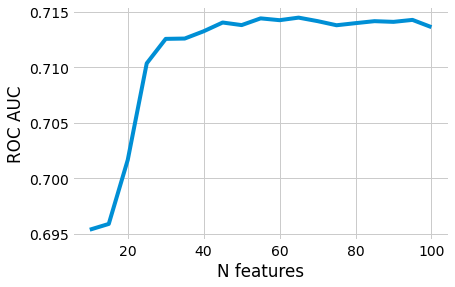

In [118]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

# ROC AUC score with all features
score = cross_val_score(lgbm, X_train, y_train, scoring='roc_auc',
                        cv=cv, n_jobs=-1)
print(f"{X_smote.shape[1]} features: {score.mean():.3}")
# Select the top 100 features
sfm_scores = []
sfm = SelectFromModel(lgbm, threshold=-np.inf, max_features=100)
X_sfm = sfm.fit_transform(X_train, y_train)
score = cross_val_score(lgbm, X_sfm, y_train,
                            scoring='roc_auc',
                            cv=cv, n_jobs=-1)
sfm_scores.append(score.mean())
# Test different numbers of features from 50 to 100
for i in range(95, 5, -5):
    sfm = SelectFromModel(lgbm, threshold=-np.inf, max_features=i)
    X_sfm = sfm.fit_transform(X_sfm, y_train)
    score = cross_val_score(lgbm, X_sfm, y_train,
                            scoring='roc_auc',
                            cv=cv, n_jobs=-1)
    sfm_scores.append(score.mean())
# Plot the results
plt.plot(np.arange(10, 105, 5), sfm_scores[::-1])
plt.xlabel("N features")
plt.ylabel("ROC AUC") 
plt.show()  

We may notice that the model performance is not impacted until 45 features. We will keep then only 45 features.

In [119]:
selector = SelectFromModel(lgbm, threshold=-np.inf, max_features=45)

pipeline = imbpipe.Pipeline([
           ('cleaning', full_pipeline),
           #('over', SMOTE(n_jobs=1, random_state=42)),  
           #('under', RandomUnderSampler(random_state=42)),
           ('feature_selection', selector),
           ('model', lgbm)
           ])

In [120]:
# Display the model results
t0 = time.time()
pipeline.fit(X, y_train)
t1 = time.time()
y_pred = pipeline.predict_proba(X)
y_pred_cv = cross_val_predict(pipeline, X, y_train, cv=cv, n_jobs=-1,
                              method="predict_proba")

time_fit = t1 - t0
score = roc_auc_score(y_train, y_pred[:, 1])
cv_score = roc_auc_score(y_train, y_pred_cv[:, 1])

pd.DataFrame(np.array([time_fit, score, cv_score.mean()]).reshape(1, -1),
             columns=['fit time (s)', 'ROC AUC', 'CV ROC AUC'])   

,fit time (s),ROC AUC,CV ROC AUC
0,8.577048,0.753885,0.713615


In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(lgbm, n_features_to_select=40, step=5, verbose=1)
X_40 = rfe.fit_transform(X_train, y_train)
mask_40 = rfe.support_
forest.fit(X_40, y_smote)
print(f"{X_40.shape[1]} features: {forest.oob_score_:.2%}")


## Fine-Tune the hyperparameters

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(5, shuffle=True, random_state=42)
forest = RandomForestClassifier(random_state=42,
                                bootstrap=True,
                                n_jobs=-1)
param_grid = {'max_features': np.arange(4, 13)}

grid_search = HalvingGridSearchCV(forest, param_grid, cv=cv,
                                  n_jobs=-1, verbose=1,
                                  random_state=42)
grid_search.fit(X_40, y_smote)
forest = grid_search.best_estimator_
print(grid_search.best_params_)

### XGBoost

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from xgboost import XGBClassifier

cv = StratifiedKFold(3, shuffle=True, random_state=42)
xgb = XGBClassifier(n_estimators=100,
                    random_state=42)
                                                              
param_grid = [{'learning_rate': [0.02, 0.05, 0.1, 0.2],
              'max_depth': [6, 8, 10, 12, 15, 20]}]
grid_search = HalvingGridSearchCV(xgb, param_grid, factor=5,
                                  cv=cv, verbose=1,
                                  n_jobs=-1, random_state=42)
grid_search.fit(X_40, y_smote, eval_metric='logloss')
xgb = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data set into a train and test set
# to use early stopping
X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(X_40, y_smote, random_state=42)

xgb.fit(X_gb_train, y_gb_train,
        eval_set=[(X_gb_test, y_gb_test)],
        eval_metric='logloss',
        early_stopping_rounds=3,
        verbose=False)
xgb.n_estimators = xgb.best_iteration + 1
print("The best iteration is {}".format(xgb.n_estimators))

### LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=100,
                      random_state=42)

param_grid = {'learning_rate': [0.02, 0.05, 0.1, 0.2, 0.3],
              'max_depth': [6, 8, 10, 12, 15, 20]}
grid_search = GridSearchCV(lgbm, param_grid, cv=cv,
                           verbose=1, n_jobs=-1)
grid_search.fit(X_40, y_smote)
lgbm = grid_search.best_estimator_
print(grid_search.best_params_)

In [ ]:
lgbm.fit(X_gb_train, y_gb_train,
         eval_set=[(X_gb_test, y_gb_test)],
         early_stopping_rounds=3,
         verbose=False)
lgbm.n_estimators = lgbm.best_iteration_
print("The best iteration is {}".format(lgbm.n_estimators))

### Catboost

In [ ]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(n_estimators=100,
                              random_state=42)

param_grid = {'learning_rate': [0.02, 0.05, 0.1, 0.2],
              'max_depth': [6, 8, 10, 12, 15]}
grid_search = HalvingGridSearchCV(catboost, param_grid, factor=5,
                                  cv=cv, verbose=1,
                                  n_jobs=-1, random_state=42)
grid_search.fit(X_40, y_smote, verbose=False)
catboost = grid_search.best_estimator_
print(grid_search.best_params_)

### Compare Results

In [ ]:
# Display the results in a DataFrame
models = {'XGBoost Classifier': xgb,
          'LightGBM Classifier': lgbm,
          'CatBoost Classifier': catboost,
          'Random Forest Classifier': forest}
compare_models(X_40, y_smote, models)

Fine tuning hyperparameters leads to a slight improvement of results.  
The best model is **Random Forest**.

### Best model

Let's increase the number of tree of the Random Forest to 500 to increase the preformance of the final model.

In [ ]:
forest.n_estimators = 500
print(forest.get_params())
compare_models(X_40, y_smote, {'Random Forest Classifier': forest})

## Analyse feature importance with SHAP